In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from pyscipopt import Model, SCIP_STATUS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# RD 天數
max_rd = 18

# period 參數
min_time = 1
max_time = max_rd * 15

In [4]:
'''需求模型'''
class demandmodel:
    def __init__(self):
        self.seat_set = ['Y', 'M', 'K']
        self.seat_price = {'Y': 800, 'M': 500, 'K': 450}  
        self.total_booking = 105
        self.market_share = 0.25
        self.gamma = 0.08426
        self.alpha = 0.001251
        self.beta = {'DFARE':-0.006, 'LOT3':-0.944}
        self.a = {'Y':{'DFARE':800, 'LOT3':1},
                  'M':{'DFARE':500, 'LOT3':1},
                  'K':{'DFARE':450, 'LOT3':1},
                 }
        self.fare_diff_avg = sum(self.seat_price.values()) / len(self.seat_price)

        for seat_type in self.a:
            self.a[seat_type]['DFARE'] = round(self.a[seat_type]['DFARE'] - self.fare_diff_avg, 2)

    def dm(self):
        dm = self.total_booking/self.market_share
        return dm

    def booking_curve(self, RD2, RD1):
        booking_curve = math.exp(-self.gamma*RD2)-math.exp(-self.gamma*RD1)
        return booking_curve

    def find_pj1(self, seat):
        smaller_keys = [key for key in self.seat_price.keys() if key < seat]
        if smaller_keys:
            max_smaller_key = max(smaller_keys)
            pj1 = self.seat_price[max_smaller_key]
        else:
            pj1 = min(self.seat_price.values())
        return pj1

    def mnl(self):
        choose_prob = {}
        value_dict = {}
        for seat in self.seat_set:
            result = {key: self.beta[key] * value for key, value in self.a[seat].items()}
            total = sum(result.values())
            value = math.exp(total)
            value_dict[seat] = value
        for seat in value_dict:
            exp_value = math.exp(value_dict[seat])
            choose_prob[seat] = exp_value / sum(math.exp(value) for value in value_dict.values())
        print("mnl: ", choose_prob)
        return choose_prob

    def customer_choice(self, seat_type):
        total_sum = 0
        choose_prob = self.mnl()
        min_key = min(self.seat_price, key=self.seat_price.get)
        p0 = self.seat_price[min_key]
        for seat in self.seat_set:
            # pj = self.seat_price[seat]
            # pj1 = self.find_pj1(seat)
            pj = self.seat_price['Y'] # 暫時寫這樣
            pj1 = self.seat_price['M'] # 暫時寫這樣
            print('p0: ',p0 , 'p1: ', pj, 'pj1: ', pj1)
            sum_of_set = (math.exp(-self.alpha*(pj-p0))-math.exp(-self.alpha*(pj1-p0))) * choose_prob[seat_type] 
            print('sum of set: ', sum_of_set)
            total_sum += sum_of_set
        return total_sum

    def formulation(self, RD2, RD1):
        dm = self.dm()
        print('dm',dm)
        booking_curve = self.booking_curve(RD2, RD1)
        print('booking curve: ',booking_curve)
        BR_dict = {}
        
        for seat in self.seat_set:
            print("calculate", seat, " ing...")
            customer_choice = self.customer_choice(seat)
            print('customer choice', customer_choice)
            BR = dm * booking_curve * customer_choice
            BR_dict[seat] = BR
            print(' seat: ', seat, ' predicted demand model from ', RD2,' to ', RD1, 'is', BR)
        return BR_dict

In [5]:
model = demandmodel()

# 存儲資訊的字典們
every_rd = {seat: [] for seat in model.seat_set}  
cumulative_demand = {seat: [] for seat in model.seat_set}  
total_demand = {seat: 0 for seat in model.seat_set}  
cumulative_total_demand_per_rd = []  # 存儲每個RD的累積總需求

# 計算所有RD需求
cumulative_total_demand = 0  # 初始累積總需求
for i in range(2, max_rd+1):
    print('i: ', i)
    BR_results = model.formulation(i, i-1)  
    total_demand_rd = sum(BR_results.values())  # 計算每個時間段的總需求
    cumulative_total_demand += total_demand_rd  # 更新累積總需求
    cumulative_total_demand_per_rd.append(cumulative_total_demand)  # 將累積總需求添加到列表中
    for seat, demand in BR_results.items():  
        every_rd[seat].append(demand) 
        total_demand[seat] += demand  
        cumulative_demand[seat].append(total_demand[seat])  

print('Total demand for each seat: ', total_demand)
print('Total demand: ', sum(total_demand.values()))

i:  2
dm 420.0
booking curve:  -0.07427787007997011
calculate Y  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
customer choice -0.18196706312950472
 seat:  Y  predicted demand model from  2  to  1 is 5.67677286706617
calculate M  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
customer choice -0.3108302335430788
 seat:  M  predicted demand model from  2  to  1 is 9.696879235696622
calculate K  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.12967773

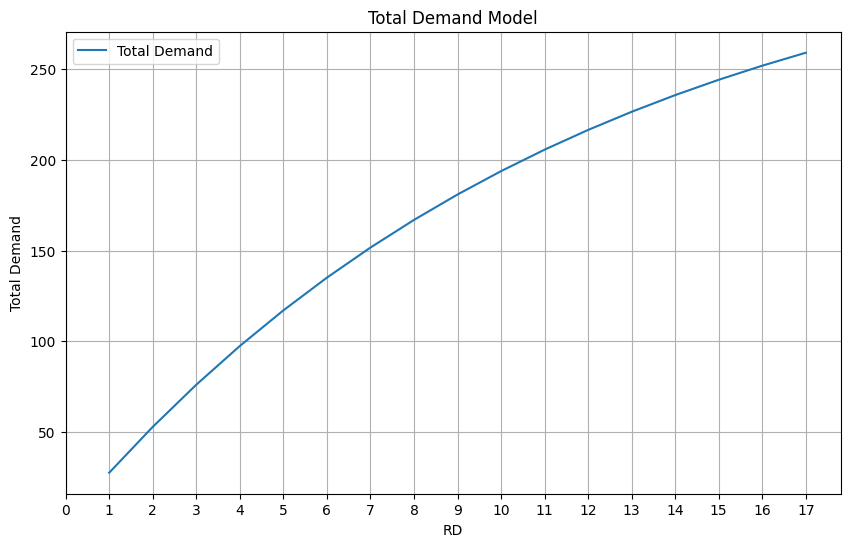

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_rd), cumulative_total_demand_per_rd, label='Total Demand')
plt.xlabel('RD')
plt.ylabel('Total Demand')
plt.title('Total Demand Model')
plt.legend()
plt.xticks(range(0, max_rd, int(max_rd/10)))
plt.grid(True)
plt.show()

In [7]:
def solve_NHPP(min_time, max_time, y2, y5, y8, total_demand):

    # 創建 SCIP 模型
    model = Model("NHPP")

    # 三角形 1
    x1 = model.addVar(vtype="I", name="x1")
    x2 = model.addVar(vtype="I", name="x2")
    x3 = model.addVar(vtype="I", name="x3")
    
    # 三角形 2
    x4 = model.addVar(vtype="I", name="x4")
    x5 = model.addVar(vtype="I", name="x5")
    x6 = model.addVar(vtype="I", name="x6")
    
    # 三角形 3
    x7 = model.addVar(vtype="I", name="x7")
    x8 = model.addVar(vtype="I", name="x8")
    x9 = model.addVar(vtype="I", name="x9")

    # 限制式
    model.addCons((x3-x1)*y2/2 >= 5)
    model.addCons((x6-x4)*y5/2 >= 5)
    model.addCons((x9-x7)*y8/2 >= 5)
    
    # 添加所有變數大於等於 0 的限制
    model.addCons(x1 >= min_time)
    model.addCons(x2 >= min_time + int(max_time/10))
    model.addCons(x3 >= max_time)
    model.addCons(x4 >= min_time)
    model.addCons(x5 >= min_time + int(max_time/10))
    model.addCons(x6 >= min_time)
    model.addCons(x7 >= min_time + 40)
    model.addCons(x8 >= max_time - 50)
    model.addCons(x9 >= min_time)
    
    # 上限
    model.addCons(x1 <= min_time)
    model.addCons(x2 <= max_time)
    model.addCons(x3 <= max_time)
    model.addCons(x4 <= min_time)
    model.addCons(x5 <= max_time)
    model.addCons(x6 <= max_time - 90)
    model.addCons(x7 <= min_time + 60)
    model.addCons(x8 <= max_time - 30)
    model.addCons(x9 <= max_time)
    
    
    # 限制 x1、x2、x3 的順序
    model.addCons(x1 <= x2)
    model.addCons(x2 <= x3)
    
    # 限制 x4、x5、x6 的順序
    model.addCons(x4 <= x5)
    model.addCons(x5 <= x6)
    
    # 限制 x7、x8、x9 的順序
    model.addCons(x7 <= x8)
    model.addCons(x8 <= x9 - 10)

    # 限制 x7、x8、x9 的順序
    model.addCons(x2 <= x8 - 80)
    model.addCons(x5 <= x2 - 50)

    model.addCons((x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2 <= total_demand)
    model.addCons(0 <= (x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2)

    # 最小化面積與總需求差距
    obj = total_demand - ((x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2)
    model.setObjective(obj, "minimize")

    # 求解
    model.optimize()
    obj_set = model.getBestSol()
    print("obj set：", obj_set)
    obj_value = model.getObjVal()
    print("obj： ", obj_value)
    
    # 解
    x1_val = model.getVal(x1)
    x2_val = model.getVal(x2)
    x3_val = model.getVal(x3)
    x4_val = model.getVal(x4)
    x5_val = model.getVal(x5)
    x6_val = model.getVal(x6)
    x7_val = model.getVal(x7)
    x8_val = model.getVal(x8)
    x9_val = model.getVal(x9)

    return x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val

    
# 測試函式
total_demand_sim = int(sum(total_demand.values()))
print(total_demand_sim)
max_Y = 0.3
max_M = 0.85
max_K = 0.85
result = solve_NHPP(min_time, max_time, max_Y, max_M, max_K, total_demand_sim)
if result:
    x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val = result
    print("x1:", x1_val)
    print("x2:", x2_val)
    print("x3:", x3_val)
    print("x4:", x4_val)
    print("x5:", x5_val)
    print("x6:", x6_val)
    print("x7:", x7_val)
    print("x8:", x8_val)
    print("x9:", x9_val)

259
obj set： {'x1': 1.0, 'x2': 140.0, 'x3': 270.0, 'x4': 1.0, 'x5': 28.0, 'x6': 180.0, 'x7': 41.0, 'x8': 220.0, 'x9': 270.0}
obj：  45.25
x1: 1.0
x2: 140.0
x3: 270.0
x4: 1.0
x5: 28.0
x6: 180.0
x7: 41.0
x8: 220.0
x9: 270.0


In [8]:
'''繪製 NHHP 三角形'''
def NHHP_triangle(min_val, max_val, left, middle, right, color='b', name=''):
    
    # 檢查中間端點的y值是否在 0 到 1 之間
    if not (0 <= middle[1] <= 1):
        print("錯誤：中間端點的y值必須在0到1之間")
        return
    
    # 計算三角形的頂點
    x1, _ = left
    x2, y2 = middle
    x3, _ = right
    
    # 計算三角形上的 y 值
    y1 = 0.0
    y3 = 0.0
    
    # 為了繪製三角形，創建 x 和 y 的坐標陣列
    x = [x1, x2, x3, x1] # 左、中、右端點構成三角形的四個點（第四個點是第一個點，閉合三角形）
    y = [y1, y2, y3, y1]
    
    # 繪製三角形
    plt.plot(x, y, color + '-', label=name)

In [9]:
# 三角形 1 的端點
left_point_y = (x1_val, 0)  # 左端點
middle_point_y = (x2_val, max_Y)  # 中間端點
right_point_y = (x3_val, 0)  # 右端點

# 三角形 2 的端點
left_point_m = (x4_val, 0)  # 左端點
middle_point_m = (x5_val, max_M)  # 中間端點
right_point_m = (x6_val, 0)  # 右端點

# 三角形 3 的端點
left_point_k = (x7_val, 0)  # 左端點
middle_point_k = (x8_val, max_K)  # 中間端點
right_point_k = (x9_val, 0)  # 右端點

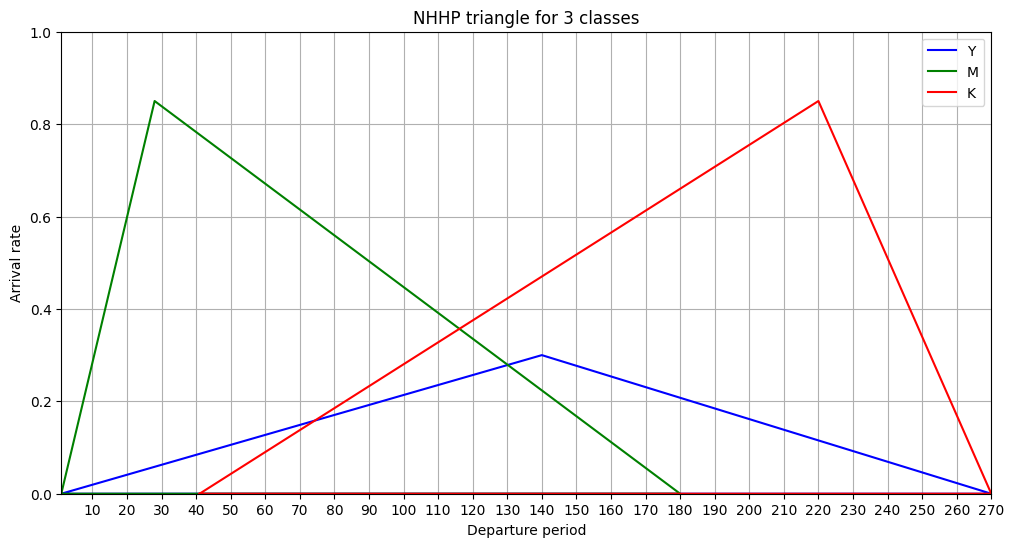

In [10]:
# 繪製三角形並為其命名
NHHP_triangle(min_time, max_time, left_point_y, middle_point_y, right_point_y, color='b', name='Y')
NHHP_triangle(min_time, max_time, left_point_m, middle_point_m, right_point_m, color='g', name='M')
NHHP_triangle(min_time, max_time, left_point_k, middle_point_k, right_point_k, color='r', name='K')

# 設置圖形的標題和坐標軸標籤
plt.title('NHHP triangle for 3 classes')
plt.xlabel('Departure period')
plt.ylabel('Arrival rate')

# 設置 x 軸刻度以 10 為單位顯示到最後
plt.xticks(range(min_time-1, max_time+1, 10))

# 設置 x 和 y 軸範圍
plt.xlim(min_time, max_time)
plt.ylim(0, 1)

# 設置圖的寬度
plt.gcf().set_size_inches(12, 6)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.grid(True)
plt.show()

In [11]:
'''使用線性差值法計算數值'''
def interpolate(x, x1, y1, x2, y2):
    return round(y1 + (x - x1) * (y2 - y1) / (x2 - x1), 3)

In [12]:
'''將三角形轉換成 NHHP'''
def NHHP(min_val, max_val, left, middle, right, color='b'):
    
    # 檢查中間端點的 y 值是否在 0 到 1 之間
    if not (0 <= middle[1] <= 1):
        print("錯誤：中間端點的 y 值必須在0到1之間")
        return
    
    # 設定端點
    x1, y1 = left
    x2, y2 = middle
    x3, y3 = right
    
    # 儲存 x 對應到中間點直線的 y 值列表
    interpolated_y_values = []
    
    # 對每個 x 值進行線性插值計算
    for x in range(min_val, max_val + 1):
        
        # 如果 x 在左端點和中間點之間
        if x1 <= x <= x2:
            interpolated_y = interpolate(x, x1, y1, x2, y2)
            interpolated_y_values.append(interpolated_y)
        
        # 如果 x 在中間點和右端點之間
        elif x2 <= x <= x3:
            interpolated_y = interpolate(x, x2, y2, x3, y3)
            interpolated_y_values.append(interpolated_y)
        
        # 如果 x 超出右端點範圍，將 y 值設置為 0
        elif x > x3:
            # print(x)
            interpolated_y_values.append(0.0)
        
        # 如果 x 超出範圍，y 設 0
        else:
            interpolated_y_values.append(0.0)
    
    # 返回 x 對應到中間點直線的 y 值列表
    return interpolated_y_values

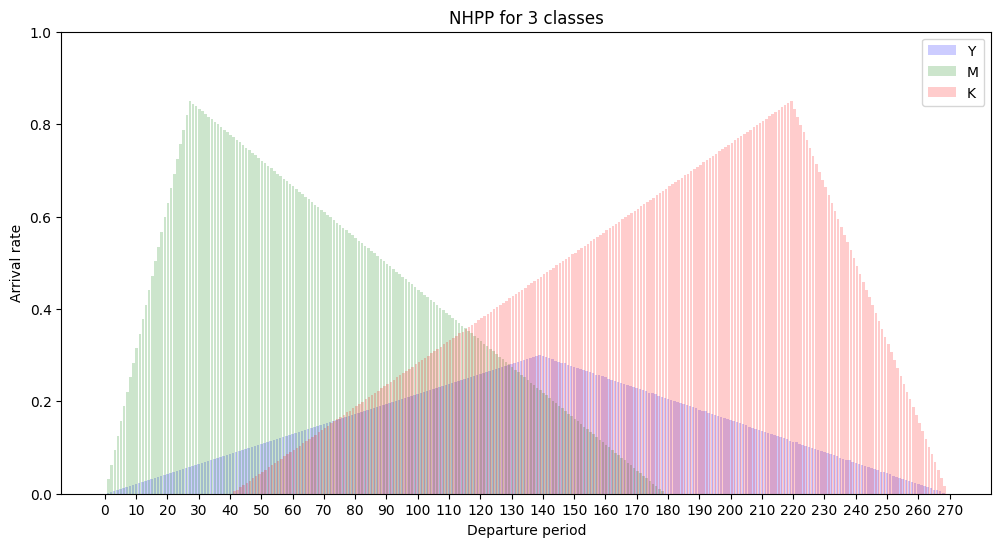

In [13]:
# 儲存每個三角形的 x 值列表和名稱的字典
triangle_data = {
    'Y': (left_point_y, middle_point_y, right_point_y),
    'M': (left_point_m, middle_point_m, right_point_m),
    'K': (left_point_k, middle_point_k, right_point_k)
}

# 儲存每個三角形的 x 值列表和名稱的字典
triangle_y_values = []

# 調用函數繪製三角形並儲存 x 值列表
for name, points in triangle_data.items():
    left, middle, right = points
    y_values = NHHP(min_time, max_time, left, middle, right)
    triangle_y_values.append((y_values, name))

# 取得每個三角形的 x 值範圍
x_values = range(min_time-1, max_time)

# 創建圖形和子圖
plt.figure(figsize=(10, 5))
plt.title('NHPP for 3 classes')
plt.xlabel('Departure period')
plt.ylabel('Arrival rate')

# 遍歷三個三角形的 Y 值列表並繪製長條圖
for i, (y_values, name) in enumerate(triangle_y_values):
    # 調整 x 軸值，讓每個三角形的長條圖不會重疊在一起
    x_offset = i * 0.2  # 調整此值以設定長條圖的間距
    colors = ['b', 'g', 'r'] # 指定顏色
    plt.bar([x + x_offset for x in x_values], y_values, alpha=0.2, label=name, color=colors[i])

# 顯示圖例
plt.legend()

# 設置圖的寬度
plt.gcf().set_size_inches(12, 6)

# 設置 x 軸刻度以 10 為單位顯示到最後
plt.xticks(range(min_time-1, max_time+1, 10))

# 設置 y 軸範圍，將高度固定為1
plt.ylim(0, 1)

# 顯示圖形
plt.show()

In [14]:
'''檢查 NHHP 是否符合要求，同時計算到達率'''
def check_NHHP(triangle_y_values):
    
    # 獲取每個三角形的 Y 值列表的長度
    y_length = len(triangle_y_values[0][0])

    # 初始化標誌變數，用於標記是否有任何索引位置的加總值大於1
    has_greater_than_1 = False
    
    # 儲存每個索引位置的加總值
    arrival_rates = []
    non_arrival_rates = []

    # 遍歷每個索引位置
    for i in range(y_length):

        total = 0 # 初始化每個三角形的加總值
        print('Departure day:', i + 1)
        
        # 遍歷每個三角形的 Y 值列表
        for y_values, name in triangle_y_values:
            
            # 獲取當前索引位置的值並加總
            value = y_values[i]
            total += value
            
            # 印出 Y[i]、M[i]、K[i] 以及加總值
            print(f'{name}[{i}] = {value}')

        # 儲存每個索引位置的加總值
        total = round(total, 3)
        arrival_rates.append(total)
        
        # 如果加總值大於1，印出相應的資訊並設置標誌變數
        if total > 1:
            print(f'在索引 {i} 位置的加總值為 {total} 大於 1')
            has_greater_than_1 = True
        
        # 印出三個列表在當前索引位置的加總值
        print(f'Total = {total}')
    
    # 如果沒有任何索引位置的加總值大於1，回傳True；否則，回傳False
    return not has_greater_than_1, arrival_rates

In [29]:
# 執行
result, arrival_rates = check_NHHP(triangle_y_values)
print(triangle_y_values)
print(triangle_y_values[0])
print(type(triangle_y_values[0]))
print('\nNHHP acceptable\n' if result else '\nNHHP not acceptable\n')

Departure day: 1
Y[0] = 0.0
M[0] = 0.0
K[0] = 0.0
Total = 0.0
Departure day: 2
Y[1] = 0.002
M[1] = 0.031
K[1] = 0.0
Total = 0.033
Departure day: 3
Y[2] = 0.004
M[2] = 0.063
K[2] = 0.0
Total = 0.067
Departure day: 4
Y[3] = 0.006
M[3] = 0.094
K[3] = 0.0
Total = 0.1
Departure day: 5
Y[4] = 0.009
M[4] = 0.126
K[4] = 0.0
Total = 0.135
Departure day: 6
Y[5] = 0.011
M[5] = 0.157
K[5] = 0.0
Total = 0.168
Departure day: 7
Y[6] = 0.013
M[6] = 0.189
K[6] = 0.0
Total = 0.202
Departure day: 8
Y[7] = 0.015
M[7] = 0.22
K[7] = 0.0
Total = 0.235
Departure day: 9
Y[8] = 0.017
M[8] = 0.252
K[8] = 0.0
Total = 0.269
Departure day: 10
Y[9] = 0.019
M[9] = 0.283
K[9] = 0.0
Total = 0.302
Departure day: 11
Y[10] = 0.022
M[10] = 0.315
K[10] = 0.0
Total = 0.337
Departure day: 12
Y[11] = 0.024
M[11] = 0.346
K[11] = 0.0
Total = 0.37
Departure day: 13
Y[12] = 0.026
M[12] = 0.378
K[12] = 0.0
Total = 0.404
Departure day: 14
Y[13] = 0.028
M[13] = 0.409
K[13] = 0.0
Total = 0.437
Departure day: 15
Y[14] = 0.03
M[14] = 0.

In [16]:
'''動態規劃、FCFS 模擬結果'''
dp = 49331
fcfs = 31221

'''初始化 AirlineEnvironment 參數'''
max_time = max_time+1 # 最大時間
seat_combination = ['Y', 'M', 'K', 'YM', 'YK', 'MK', 'YMK']
seat_combination_test = [0, 1, 2, 3, 4, 5, 6]
seat_limit = 80

'''初始化 Q-Learning Agent 超參數'''
num_x = seat_limit + 1 # 總座位數量 num_x 的數量
num_t = max_time + 1 # 時間 t 的離散化數量
num_actions = len(seat_combination) # 可執行的動作數量

'''初始化 DQNAgent 超參數'''
num_state = 2 # state 的變數數量
num_actions = len(seat_combination) # 可執行的動作數量

In [17]:
class ListActionSpace:
    def __init__(self, action_list):
        self.action_list = action_list
        self.n = len(action_list)  # 動作的數量

    def sample(self):
        return np.random.choice(self.action_list)

    def contains(self, action):
        return action in self.action_list

# 創建一個列表動作空間
action_list = [0, 1, 2, 3, 4, 5, 6]
action_space = ListActionSpace(action_list)
print(type(action_space))

# 範例使用
action = action_space.sample()
print("Sampled action:", action)

print("Action space size:", action_space.n)
print("Is 'up' in action space?", action_space.contains('up'))
print("Is 'jump' in action space?", action_space.contains('jump'))

<class '__main__.ListActionSpace'>
Sampled action: 5
Action space size: 7
Is 'up' in action space? False
Is 'jump' in action space? False


In [18]:
'''Establish env with Single Cabin different fare classes'''
class AirlineEnvironment:
    
    ''' Initialize env parameters '''
    def __init__(self, max_time, action_space, seat_limit, arrival_rates):
        self.max_time = max_time # max time
        self.action_space = ListActionSpace(action_list) # inherent class action space
        self.state = (seat_limit, 1) # Initialize state : (num seat sold, period)
        self.seat_remain = seat_limit # total seat limitation
        self.customer_willingness_to_pay = {'f': 0,'Y': 800, 'M': 500, 'K': 450}  # Customer willingness to pay
        self.seat_sets = {0: 'Y', 1: 'M', 2: 'K', 3: 'YM', 4: 'YK', 5: 'MK', 6: 'YMK'} # action to seat open combination
        self.customers = {0: 'f', 1: 'Y', 2: 'M', 3: 'K'} # customer type
        self.arrival_rates = arrival_rates # arrival rates
        
        # Seat combination & seat open
        self.seat_combination = {
            'f': {'f': 0.0, 'Y': 0.0, 'M': 0.0, 'K': 0.0},
            'Y': {'f': 0.0, 'Y': 800, 'M': 0.0, 'K': 0.0},
            'M': {'f': 0.0, 'Y': 0.0, 'M': 500, 'K': 0.0},
            'K': {'f': 0.0, 'Y': 0.0, 'M': 0.0, 'K': 450},
            'YM': {'f': 0.0, 'Y': 800, 'M': 500, 'K': 0.0},
            'YK': {'f': 0.0, 'Y': 800, 'M': 0.0, 'K': 450},
            'MK': {'f': 0.0, 'Y': 0.0, 'M': 500, 'K': 450},
            'YMK': {'f': 0.0, 'Y': 800, 'M': 500, 'K': 450}
        }
        
    ''' Reset env '''
    def reset(self):
        self.seat_remain = seat_limit # Initialize total seat 
        self.state = (seat_limit, 1)  # Initialize state
        return self.state
    
    ''' Customer generation'''
    def generate_customer(self, t):
        
        # random number
        t = int(t)
        random_number = np.random.rand()
    
        # arrival rates list
        probabilities = []
        lamda = 0
        for y_values, name in self.arrival_rates:
            
            # sum up the value of related index
            value = y_values[t-1]
            lamda += value
            probabilities.append(value)
        probabilities.insert(0, 1-lamda) # f、Y、M、K
        # print(probabilities,' at day: ', t)
    
        # Decide customer type
        cumulative_probability = 0
        customer_index = 0
        for probability in probabilities:
            cumulative_probability += probability
            if random_number <= cumulative_probability:
                break
            customer_index += 1
        
        # return customer type
        customer_type = self.customers[customer_index]
        price = self.customer_willingness_to_pay[customer_type]    
        # print(f"random_number: {random_number}, customer_index: {customer_index}, customer_type: {customer_type}, price: {price}")
        return customer_type, price
    
    ''' Check customer preference & seat open '''
    def check_customer_preference(self, customer_type, choose_set):

        # Seat open
        open_seat = self.seat_combination[choose_set]

        # seat open with customer preference, return revenue
        if open_seat[customer_type] > 0:
            return self.customer_willingness_to_pay[customer_type]
        
        # seat open without customer preference, return 0 instead of revenue
        else:
            # print("No suitable seat.")
            return 0
    
    ''' Step '''
    def step(self, state, action):
        
        # Agent choose a seat combination
        choose_set = self.seat_sets[action]
        
        # print(f"Action: {action}, state: {state}, Choose_set: {choose_set}")
        # print(f"state[0, 0]: {state[0, 0]}, state[0, 1]: {state[0, 1]}")
        
        # Customer generation
        customer_type, willingness_to_pay = self.generate_customer(state[0, 1].item())
       
        # With remaining seat
        if self.seat_remain > 0:
        
            # Decide immediate revenue
            reward = self.check_customer_preference(customer_type, choose_set)

            # Update seat remain
            if reward > 0:
                self.seat_remain = self.seat_remain-1
        
        # Without remaining seat 
        else:
            # print("No remaining seat.")
            reward = 0

        # Update period
        next_time = state[0, 1].item() + 1
        # print("next_time: ", next_time)
        
        # Check departure or not 
        departure = (next_time >= max_time)

        # update state
        state[0, 0] = self.seat_remain
        state[0, 1] = next_time
        
        # print(f"state[0, 0]: {state[0, 0]}, state[0, 1]: {state[0, 1]}")
        # state = (self.seat_remain, next_time)
        return state.cpu().detach().numpy(), reward, departure

In [19]:
env = AirlineEnvironment(max_time, seat_combination_test, seat_limit, triangle_y_values)

In [20]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Define tuple structure, use tuple structure to store info
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

''' Establish Memory Replay Buffer '''
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [22]:
''' 建構 DQN '''
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [23]:
''' Reinforcement Learning Hyparameter '''
BATCH_SIZE = 128  # Batch size from experience replay buffer
GAMMA = 0.99  # Reward discount rate Gamma
EPS_START = 0.9  # Epilson-Greedy strategy's hyparameter eplison
EPS_END = 0.05 # Final value of eplison 
EPS_DECAY = 1000 # Control eplison decay，higher represent slower decay
TAU = 0.005 # Update rate of target network
LR = 1e-4 # Learning rate of optimizer

''' Simulated Environment Parameter '''
n_actions = env.action_space.n # num action
state = env.reset() # initialize env
n_observations = len(state) # num state

''' Establish Policy Network, Target Network '''
policy_net = DQN(n_observations, n_actions).to(device) # Policy Network
target_net = DQN(n_observations, n_actions).to(device) # Target Network
target_net.load_state_dict(policy_net.state_dict())
memory = ReplayMemory(10000) # Memory size of Replay Buffer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True) # AdamW optimizer

''' Agent Select Action'''
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        # Exploit：Select Max Value action
        with torch.no_grad():
            # t.max(1) return max expected value column
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Explore：Randomly select action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [24]:
''' Optimize Network '''
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) # Converts batch-array of Transitions to Transition of batch-arrays.

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [26]:
# Initialize Training parameters
num_episodes = 30
DQN_total_rewards = []
DQN_cumulative_average = []
DQN_per_50_avg = []

# Training
for episode in range(num_episodes):
    
    # Initialize environment
    print("---------- Episode ", episode, "-----------")
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0 # 初始化營收
    # print("unsqueeze state: ", state)
    
    for step in count():
        
        # print("------- step " ,step," ---------")
        
        # agent 選擇動作
        action = select_action(state)
        # print("action: ", action)

        # 這裡應該怪怪的
        observation, reward, departure = env.step(state, action.item())
        # print("observation: ", observation, "reward: ",  reward, "departure: ", departure)
        # print("type obs: ", type(observation))
        reward = torch.tensor([reward], device=device)
        done = departure

        if departure:
            next_state = None
        else:
            # print("observation: ", observation)
            observation = observation.flatten()
            # print("obs flatt", observation)
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # print("next_state: ", next_state)
            # next_state = next_state.squeeze()
            # print("next_state: ", next_state)

        # 更新總獎勵
        total_reward += reward

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break
    
    # 將每個 episode 的 total reward 加入列表中  
    DQN_total_rewards.append(total_reward.cpu().numpy()) 
    
    # 計算每50個 episode 的平均總獎勵
    if episode % 50 == 0 and episode != 0:
        DQN_per_50_avg.append(np.mean(DQN_total_rewards[-50:]))
    
    # 累積平均獎勵
    DQN_cumulative_avg = sum(DQN_total_rewards) / (episode + 1)
    DQN_cumulative_average.append(DQN_cumulative_avg)
    print(f"Episode: {episode}, Total Revenue: {total_reward}, Cumulative average: {DQN_cumulative_avg}")

---------- Episode  0 -----------
Episode: 0, Total Revenue: tensor([42500], device='cuda:0'), Cumulative average: [42500.]
---------- Episode  1 -----------
Episode: 1, Total Revenue: tensor([39500], device='cuda:0'), Cumulative average: [41000.]
---------- Episode  2 -----------
Episode: 2, Total Revenue: tensor([39900], device='cuda:0'), Cumulative average: [40633.33333333]
---------- Episode  3 -----------
Episode: 3, Total Revenue: tensor([40400], device='cuda:0'), Cumulative average: [40575.]
---------- Episode  4 -----------
Episode: 4, Total Revenue: tensor([40000], device='cuda:0'), Cumulative average: [40460.]
---------- Episode  5 -----------
Episode: 5, Total Revenue: tensor([40450], device='cuda:0'), Cumulative average: [40458.33333333]
---------- Episode  6 -----------
Episode: 6, Total Revenue: tensor([39750], device='cuda:0'), Cumulative average: [40357.14285714]
---------- Episode  7 -----------
Episode: 7, Total Revenue: tensor([39100], device='cuda:0'), Cumulative av

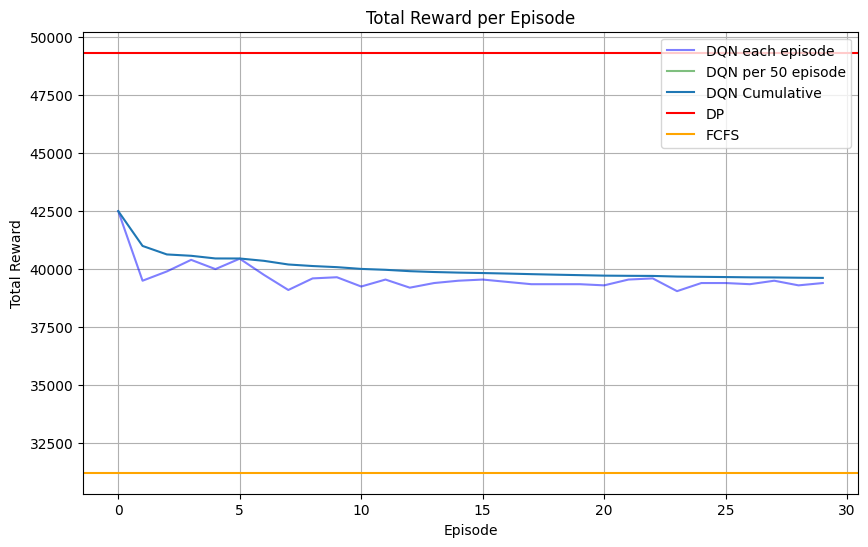

In [27]:
# Plot results
plt.figure(figsize=(10, 6))  
plt.plot(range(num_episodes), DQN_total_rewards, label='DQN each episode', alpha=0.5, color='b')
plt.plot(range(50, num_episodes, 50), DQN_per_50_avg, label='DQN per 50 episode', alpha=0.5, color='green')
plt.plot(range(num_episodes), DQN_cumulative_average, label='DQN Cumulative')
plt.axhline(y=dp, color='r', label='DP')
plt.axhline(y=fcfs, color='orange', label='FCFS')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()  
plt.grid(True)
plt.show()